# Context

Testing cluster tracking for detection and separation of individual capillary pores.

# Imports

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [62]:
from PIL import Image
import os
from skimage import exposure

In [63]:
import matplotlib
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [64]:
def show_video(frames, frames1=None, n_frames = 20, startframe=0, orient = "horizontal", figsize=(10,10), vmin=0,vmax=1,cmap="viridis", show_framenumber=True):
    if type(frames1) != type(None):
        fig, ax = [None,None]
        if orient == "horizontal":
            fig, ax = plt.subplots(1,2, figsize=figsize)
        elif orient == "vertical":
            fig, ax = plt.subplots(2,1, figsize=figsize)

        time_text = None
        if show_framenumber:
            pass

        im = ax[0].imshow(frames[0], cmap = cmap, vmin=vmin,vmax=vmax)
        im1 = ax[1].imshow(frames1[0],vmin=vmin,vmax=vmax)
        ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(frames[i]),im1.set_array(frames1[i])], frames=n_frames).to_jshtml()
        return ani
    else:
        fig, ax = plt.subplots(1, figsize=(10,10))
        im = ax.imshow(frames[0], cmap = cmap, vmin=vmin,vmax=vmax)
        ani = matplotlib.animation.FuncAnimation(fig, lambda i: im.set_array(frames[i]), frames=n_frames).to_jshtml()
        return ani

### Import our custom utility methods

In [65]:
import sys
%reload_ext autoreload
%autoreload 2

In [66]:
from cluster_tracking import FastDensityClustering

In [15]:
tensor_raw = np.load("../../XRM/XRM_10min_imb_front_3.npy")

In [16]:
tensor_raw = np.swapaxes(tensor_raw,0,2)
tensor_raw = tensor_raw[:,:128,:128]
tensor_raw -= np.min(tensor_raw)
tensor_raw /= np.max(tensor_raw)

In [17]:
#for i, img in enumerate(tensor_raw):
#    tensor_raw[i] = exposure.equalize_adapthist(img)

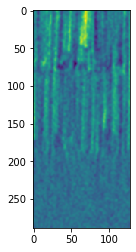

In [18]:
plt.imshow(tensor_raw[:,10,:])

In [20]:
tensor_raw -= np.min(tensor_raw)
tensor_raw /= np.max(tensor_raw)
tensor = tensor_raw<.4

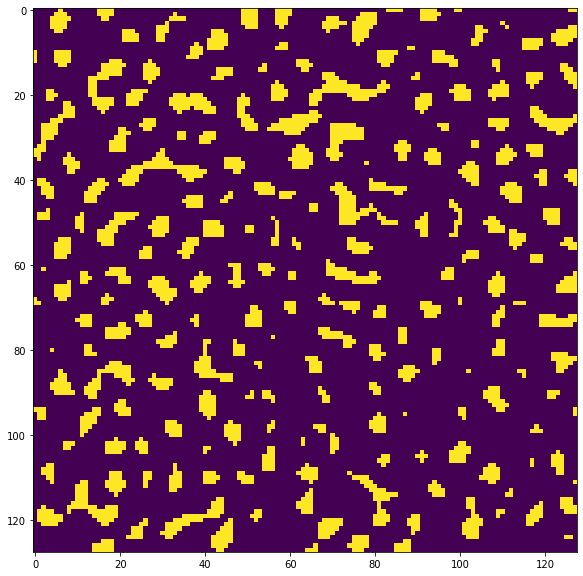

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(tensor[0])

Smooth tensor to connect slices that are incorrectly detected as seperate pieces

In [22]:
smooth = np.array(tensor, dtype=np.int64).copy()

In [23]:
smooth = gaussian_filter(np.array(tensor,dtype=np.int32)*10,[3,0,0])

In [24]:
smooth = smooth - np.min(smooth)
smooth = smooth / np.max(smooth)

In [25]:
#smooth = smooth >.5

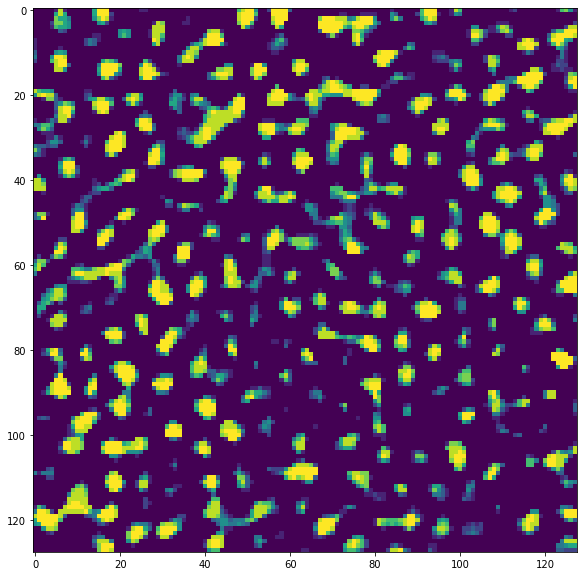

In [26]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(smooth[21])

In [175]:
if False:
    labeled_tensor = FastDensityClustering.cluster_tracking(smooth, mapp=None, 
                                                            mode="closest_center", frames = 250, search_window_size=5)
    np.save("labeled_tensor.npy", labeled_tensor)
else:
    labeled_tensor = np.load("labeled_tensor.npy")

In [176]:
np.max(labeled_tensor)

2217.0

In [177]:
size_of_cluster = np.array([np.sum(labeled_tensor==i) for i in range(int(np.max(labeled_tensor)))])

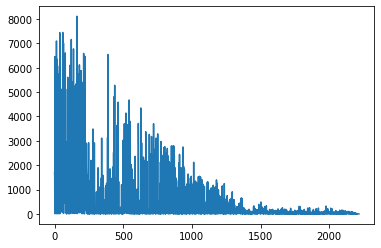

In [178]:
plt.plot(size_of_cluster)

In [179]:
np.where(size_of_cluster>2000)

(array([   3,    5,   11,   12,   14,   16,   17,   20,   21,   24,   26,
          27,   28,   29,   33,   35,   36,   37,   38,   40,   41,   43,
          46,   47,   48,   56,   57,   58,   59,   60,   65,   67,   69,
          70,   71,   73,   74,   75,   76,   77,   78,   80,   84,   85,
          94,   95,   96,   97,   98,   99,  100,  101,  102,  105,  106,
         109,  111,  112,  117,  121,  122,  124,  128,  129,  130,  131,
         136,  137,  138,  144,  145,  148,  151,  154,  155,  156,  157,
         158,  159,  160,  161,  163,  169,  170,  173,  174,  175,  181,
         187,  188,  193,  195,  197,  200,  202,  204,  208,  209,  212,
         216,  219,  220,  221,  222,  223,  225,  230,  232,  248,  266,
         280,  290,  343,  386,  388,  390,  430,  434,  437,  438,  454,
         461,  463,  500,  508,  519,  530,  534,  543,  548,  551,  557,
         587,  610,  611,  628,  634,  641,  647,  658,  664,  673,  674,
         690,  695,  706,  707,  708, 

744


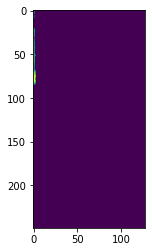

In [180]:
current_index = 9
plt.imshow(np.mean(labeled_tensor==current_index,axis=2))
print(np.sum(labeled_tensor==current_index))

744


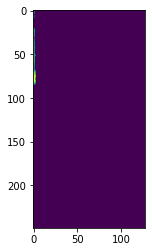

In [181]:
current_index = 9
plt.imshow(np.mean(labeled_tensor==current_index,axis=2))
print(np.sum(labeled_tensor==current_index))

In [182]:
where_column_along_z = np.argwhere(np.mean(labeled_tensor==current_index,axis=(1,2))==0).flatten()

In [183]:
def get_lower_pore_end(labeled_tensor):
    """ Returns coordinate of lower end of pore. This is achieved by checking for non-zero values in the mean along the z axis.
    """
    out = []
    for current_index in range(int(np.max(labeled_tensor))):
        where_column_along_z = np.argwhere(np.mean(labeled_tensor==current_index,axis=(1,2))!=0).flatten()
        out.append(np.max(where_column_along_z))
    return np.array(out)

In [184]:
def get_upper_pore_end(labeled_tensor):
    """ Returns coordinate of lower end of pore. This is achieved by checking for non-zero values in the mean along the z axis.
    """
    out = []
    for current_index in range(int(np.max(labeled_tensor))):
        where_column_along_z = np.argwhere(np.mean(labeled_tensor==current_index,axis=(1,2))!=0).flatten()
        out.append(np.min(where_column_along_z))
    return np.array(out)

In [185]:
lower_ends = get_lower_pore_end(labeled_tensor)
upper_ends = get_upper_pore_end(labeled_tensor)
lengths = lower_ends-upper_ends

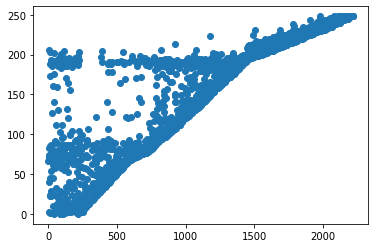

In [186]:
plt.scatter(np.arange(len(lower_ends)), lower_ends)
#plt.scatter(np.arange(len(upper_ends)), upper_ends)

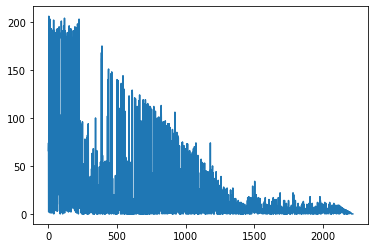

In [187]:
plt.plot(lengths)

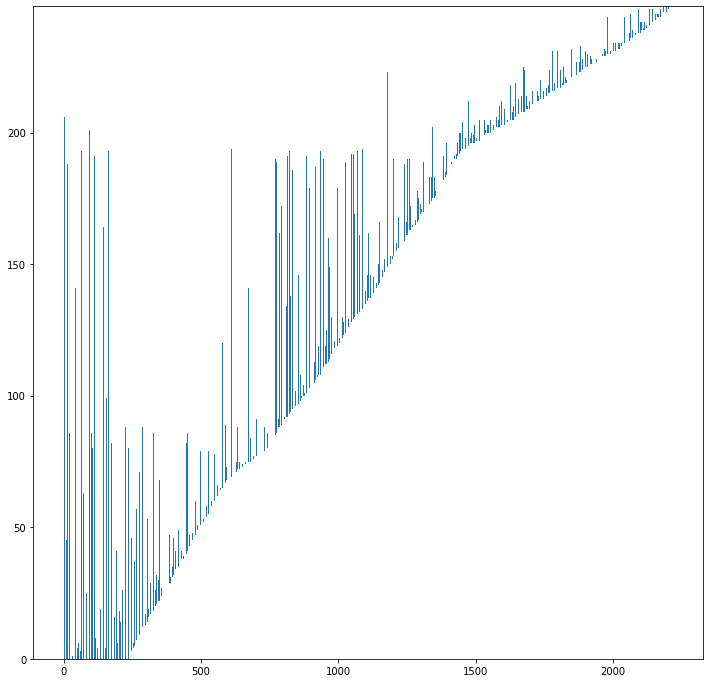

In [188]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, figsize=(12,12))

ind = np.arange(len(lower_ends))    # the x locations for the groups
width = .5

p2 = ax.bar(ind, lengths, width, bottom=upper_ends)

In [189]:
volumes = size_of_cluster[:700]

In [190]:
lengths = lengths[:700]

# Correlation of properties

The lengths and the volume of the pores is assumed to be strongly linearly correlated.

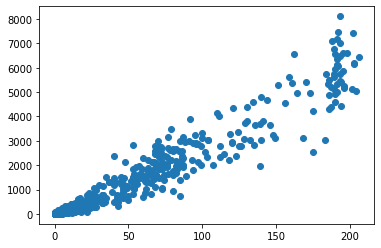

In [191]:
plt.scatter(lengths, volumes)

Does the volume per layer correlate with the length of the detected pore (empty pore/ empty up to the infiltrated part)?

In [192]:
volume_per_layer = volumes/lengths

/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



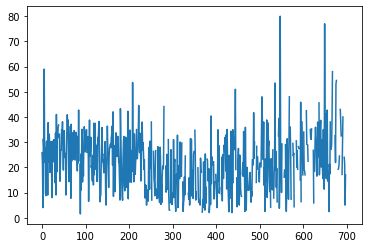

In [193]:
plt.plot(volume_per_layer)

In [194]:
valid_indices = ~np.isinf(volume_per_layer)

In [195]:
volume_per_layer, lengths = volume_per_layer[valid_indices], lengths[valid_indices]

Text(0, 0.5, 'lengths of pore')

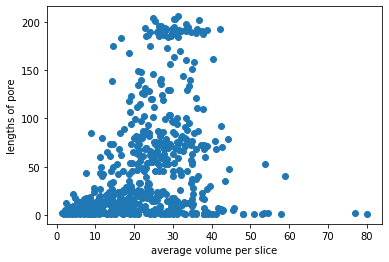

In [196]:
plt.scatter(volume_per_layer, lengths)
plt.xlabel("average volume per slice")
plt.ylabel("lengths of pore")

In [197]:
print("Pearsons r: " + str(np.corrcoef(volume_per_layer, lengths)[0,1].round(2)))

Pearsons r: 0.34


Very small empty volumes do argubly not relate to continuous pores. The imbibition front is expected to be around slice 60.

In [198]:
subset_pores = lengths > 40

In [199]:
volume_per_layer, lengths = volume_per_layer[subset_pores], lengths[subset_pores]

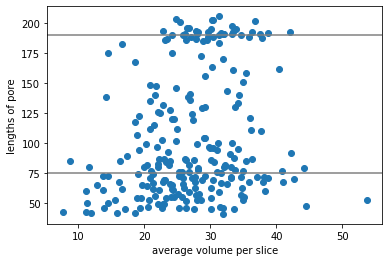

In [200]:
plt.scatter(volume_per_layer, lengths)
plt.xlabel("average volume per slice")
plt.ylabel("lengths of pore")
plt.axhline(75, c="gray")
plt.axhline(190, c="gray")

In [201]:
print("Pearsons r: " + str(np.corrcoef(volume_per_layer, lengths)[0,1].round(2)))

Pearsons r: 0.21


# Select non-empty pores

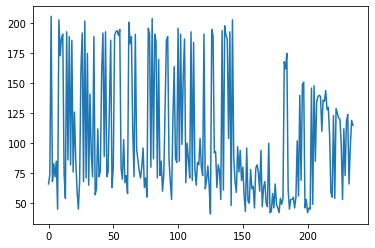

In [202]:
plt.plot(lengths)

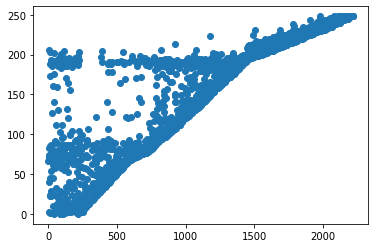

In [203]:
plt.scatter(np.arange(len(lower_ends)), lower_ends)

In [204]:
lower_ends = get_lower_pore_end(labeled_tensor)
upper_ends = get_upper_pore_end(labeled_tensor)
lengths = lower_ends-upper_ends

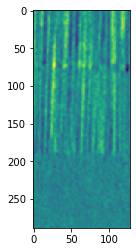

In [205]:
plt.imshow(tensor_raw[:,0,:])

# Color 3d plot

In [206]:
from plotly_voxel_plot1 import *

In [207]:
def random_color_str():
    color = list(np.random.choice(range(256), size=3))
    return "rgb"+str(tuple(color))

In [74]:
meshes = []

In [75]:
# Pores above infiltration front
tensor = np.ndarray(labeled_tensor.shape, dtype=np.bool)
for val in np.where(np.logical_and(lower_ends<100,lengths>25))[0]:#Empty columns above infiltration front
    tensor.fill(False)
    tensor[labeled_tensor == val] = 1
    mesh = voxels_to_mesh(tensor, opacity=1.0, color=random_color_str())
    meshes.extend(mesh)

In [690]:
#Empty columns
for val in np.where(np.logical_and(lower_ends>175,lower_ends<220,lengths>25))[0]:
    tensor.fill(False)
    tensor[labeled_tensor == val] = 1
    mesh = voxels_to_mesh(tensor, opacity=1.0, color=random_color_str())
    meshes.extend(mesh)

In [76]:
import plotly.graph_objects as go

#mesh = voxels_to_mesh(tensor, opacity=1.0, color="gray")
fig = go.Figure(meshes)

In [77]:
fig = fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,tensor.shape[0]],),
                     yaxis = dict(nticks=4, range=[0,tensor.shape[1]],),
                     zaxis = dict(nticks=4, range=[0,tensor.shape[2]],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

In [78]:
fig.write_html("for_volume_properties_empty_below.html")

# Correlation analysis for full pores

In [445]:
full_pores = np.where(np.logical_and(upper_ends >50, 
                                     np.logical_and(upper_ends <140, 
                                     lower_ends>180 
                                     )))[0]

In [446]:
tensor1 = labeled_tensor.copy()
tensor1.fill(-1)

In [447]:
for i, val in enumerate(full_pores):
    tensor1[labeled_tensor == val] = i

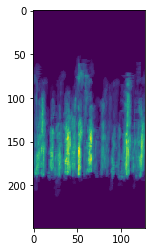

In [448]:
plt.imshow(np.mean(tensor1>0, axis=1))
#plt.axis("off")

In [449]:
np.max(tensor1)

111.0

In [434]:
# Pores above infiltration front
tensor = np.ndarray(labeled_tensor.shape, dtype=np.bool)
mesh = []
for val in np.where(np.logical_and(lower_ends<100,lengths>25))[0]:#Empty columns above infiltration front
    tensor.fill(False)
    tensor[tensor1 == val] = 1
    mesh = voxels_to_mesh(tensor, opacity=1.0, color=random_color_str())
    meshes.extend(mesh)

In [435]:
import plotly.graph_objects as go
fig = go.Figure(meshes)

In [436]:
fig = fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,tensor.shape[0]],),
                     yaxis = dict(nticks=4, range=[0,tensor.shape[1]],),
                     zaxis = dict(nticks=4, range=[0,tensor.shape[2]],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

In [437]:
fig.write_html("full_pores.html")

In [438]:
lower_ends_full = get_lower_pore_end(tensor1)
upper_ends_full = get_upper_pore_end(tensor1)
lengths_full = lower_ends_full-upper_ends_full
size_of_cluster_full = np.array([np.sum(tensor1==i) for i in range(0,int(np.max(tensor1)))])

In [439]:
volume_per_slice_full = size_of_cluster_full/lengths_full

In [440]:
m, c = np.polyfit(volume_per_slice_full, lengths_full,1)

In [441]:
x = np.linspace(np.min(volume_per_slice_full),np.max(volume_per_slice_full))

Text(0, 0.5, 'Lengths')

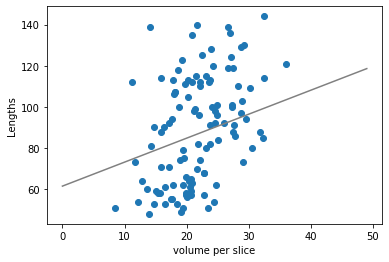

In [453]:
fig, ax = plt.subplots(1)
ax.scatter(volume_per_slice_full, lengths_full)
ax.plot(m*x+c, c ="gray")
ax.set_xlabel("volume per slice")
ax.set_ylabel("Lengths")

In [443]:
np.corrcoef(volume_per_slice_full, lengths_full)[0,1].round(2)

0.42

In [444]:
np.corrcoef(volume_per_slice_full, lower_ends_full)

array([[1.        , 0.12777209],
       [0.12777209, 1.        ]])

Correlation strengths depends a lot on the selection of columns according to the lower bound (minimal penetration 140 is set to 140 voxels). Potentially thin columns are more likely to be disconnected because of the way they are measured.

In [103]:
np.where(size_of_cluster>2000)

(array([  1,  11,  14,  15,  17,  19,  21,  25,  37,  38,  50,  59,  61,
         62,  67,  73,  77,  79,  80,  81,  88,  98,  99, 116, 124, 126,
        132, 142, 154, 160, 168, 176, 177, 187, 188, 201, 214, 220, 229,
        232, 257, 386, 510, 526]),)

In [450]:
%%capture
fig, ax = plt.subplots(1,3)
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

sel = tensor1== 0

im = ax[0].imshow(np.mean(sel, axis=0))
im1 = ax[1].imshow(np.mean(sel, axis=1))
im2 = ax[2].imshow(np.mean(sel, axis=2))


def display(i):
    print(".", end="")
    sel = tensor1== i

    im.set_array(np.mean(sel, axis=0))
    im1.set_array(np.mean(sel, axis=1))
    im2.set_array(np.mean(sel, axis=2))

ani = matplotlib.animation.FuncAnimation(fig, display, frames=int(np.max(tensor1))).to_jshtml()

In [451]:
HTML(ani)

In [22]:
np.sum(labeled_tensor == 0)

1153

In [23]:
y,x = np.where(np.mean(labeled_tensor==200, axis=0))
y_min = np.min(y)
y_max = np.max(y)
x_min = np.min(x)
x_max = np.max(x)

In [24]:
roi = labeled_tensor[:,y_min:y_max+1,x_min:x_max+1]

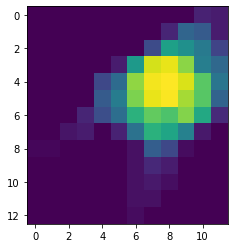

In [25]:
plt.imshow(np.mean(roi[:]==200, axis=0))

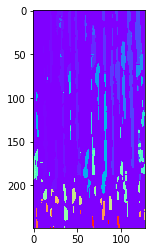

In [26]:
plt.imshow(np.median(labeled_tensor[:,:,0:5],axis=2), cmap="rainbow")

In [27]:
open("pores.html", "w").write(ani)

6226704

In [28]:
labeled_tensor = np.swapaxes(labeled_tensor,2,0)

In [29]:
roi1 = np.logical_and(labeled_tensor>0, labeled_tensor<100)

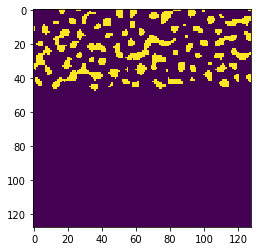

In [281]:
plt.imshow(roi1[0])

In [30]:
"""import plotly.express as px
import pandas as pd
from scipy import ndimage
def voxels_to_surface_coords(a, size=.5):
    coords = np.array(np.where(np.logical_xor(ndimage.binary_erosion(a),a).astype(np.int32))).T
    df = pd.DataFrame(coords, columns=["x","y","z"])
    size_vec = np.zeros(len(df))
    size_vec.fill(size)
    df["size"] = size_vec
    return df

fig = px.scatter_3d(voxels_to_surface_coords(roi1), 
                    x='x', y='y', z='z', size = "size", opacity=1)

fig.update_layout(
    scene = dict(
                     xaxis = dict(nticks=4, range=[0,labeled_tensor.shape[0]]),
                     yaxis = dict(nticks=4, range=[0,labeled_tensor.shape[1]]),
                     zaxis = dict(nticks=4, range=[0,labeled_tensor.shape[2]]),
    ),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
#fig.show()"""

'import plotly.express as px\nimport pandas as pd\nfrom scipy import ndimage\ndef voxels_to_surface_coords(a, size=.5):\n    coords = np.array(np.where(np.logical_xor(ndimage.binary_erosion(a),a).astype(np.int32))).T\n    df = pd.DataFrame(coords, columns=["x","y","z"])\n    size_vec = np.zeros(len(df))\n    size_vec.fill(size)\n    df["size"] = size_vec\n    return df\n\nfig = px.scatter_3d(voxels_to_surface_coords(roi1), \n                    x=\'x\', y=\'y\', z=\'z\', size = "size", opacity=1)\n\nfig.update_layout(\n    scene = dict(\n                     xaxis = dict(nticks=4, range=[0,labeled_tensor.shape[0]]),\n                     yaxis = dict(nticks=4, range=[0,labeled_tensor.shape[1]]),\n                     zaxis = dict(nticks=4, range=[0,labeled_tensor.shape[2]]),\n    ),\n    width=700,\n    margin=dict(r=20, l=10, b=10, t=10))\n#fig.show()'

In [31]:
#fig.write_html(file="pores_points.html")

In [143]:
from plotly_voxel_plot1 import *

In [145]:
# Full pores
tensor = np.ndarray(labeled_tensor.shape, dtype=np.bool)
tensor.fill(False)
for val in np.where(size_of_cluster>1000)[0]:
    tensor[labeled_tensor == val] = 1
    
if False:
    tensor = ~tensor

In [139]:
# Empty pores
tensor = np.ndarray(labeled_tensor.shape, dtype=np.bool)
tensor.fill(False)
for val in np.where(size_of_cluster<500)[0]:
    tensor[labeled_tensor == val] = 1

In [146]:
import plotly.graph_objects as go

if False:#Small original
    tensor = labeled_tensor.copy()>0
    tensor = np.pad(tensor[:50,:50,160:160+50],1)

mesh = voxels_to_mesh(tensor, opacity=0.7, color="gray")
fig = go.Figure(mesh)

In [147]:
fig = fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,tensor.shape[0]],),
                     yaxis = dict(nticks=4, range=[0,tensor.shape[1]],),
                     zaxis = dict(nticks=4, range=[0,tensor.shape[2]],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

In [148]:
fig.write_html(file="pores1.html")

In [149]:
top, bottom, left, right, back, front = get_surface_voxels(np.pad(roi2,1))